### **Understanding the Problem**

#### In this notebook, we develop a solution for automating accounting entries using a neural network model based on the T5 architecture.  

##### The code has been designed as a complete application, where each step described in this notebook has been encapsulated into modular and independent functions. This means that processes such as data reading and preprocessing, dataset creation, model training, and the generation and validation of accounting entries are implemented as standalone functions. These functions are invoked from the graphical user interface to provide an interactive experience.

### **Process Overview:**
- **Data Reading & Preprocessing:** Read Excel files containing bank movements, the accounting plan, billing registry, and accounting journal.
- **Dataset Creation:** Build training pairs from the accounting journal.
- **Model Training:** Train a T5 model using a custom PyTorch dataset.
- **Evaluation:** Generate accounting entries from bank movements and perform basic validation.
- **Model Saving:** Save the trained model (using pickle) in the `src/models` folder.

### **Step 1: Importing Libraries, and Reading and preprocessing of the Excel files**

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import T5ForConditionalGeneration, T5Tokenizer, AdamW
import json
import threading
import tkinter as tk
from tkinter import scrolledtext, messagebox
from tkinter import ttk
from tkinter import filedialog
from PIL import Image, ImageTk  # Requiere: pip install pillow
import os
import warnings
from IPython.display import Image, display
import shutil
import re

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# =============================================================================
# 1. Lectura y Preprocesamiento de los archivos Excel
# =============================================================================

def leer_datos():
    """
    Lee los archivos Excel del proyecto:
      - Movimientos bancarios
      - Plan contable
      - Registro de facturación
      - Diario contable
    """
    movimientos = pd.read_excel("../data_sample/bancos/train_data.xlsx")
    plan_contable = pd.read_excel("../data_sample/contabilidad/plan_contable.xlsx")
    diario_contable = pd.read_excel("../data_sample/contabilidad/diario_contable.xlsx")
    return movimientos, plan_contable, diario_contable

def preprocesar_movimientos(movimientos):
    movimientos['input_text'] = (
        "Genera asiento contable: " +
        movimientos['Fecha'].astype(str) + " " +
        movimientos['Movimiento'].astype(str) + " " +
        movimientos['Importe'].astype(str) + " " +
        movimientos['Más datos'].astype(str)
    )
    return movimientos


### **Step 2: Creation of the Training Dataset from the Accounting Journal**

In [15]:
# =============================================================================
# 2. Creación del Dataset de Entrenamiento a partir del Diario Contable
# =============================================================================

def generar_pares_movimiento_asiento(movimientos: pd.DataFrame, diario_contable: pd.DataFrame, tolerancia=0.01):
    pares = []
    diario_agrupado = diario_contable.groupby("Asiento")
    resumen_asientos = []
    
    # Preparar resumen de asientos agrupando el diario
    for asiento_id, grupo in diario_agrupado:
        try:
            fecha = pd.to_datetime(grupo["Fecha"].iloc[0], dayfirst=True)
        except Exception:
            continue  # Saltar si la fecha no es válida
        
        total_debe = grupo["Debe"].sum()
        total_haber = grupo["Haber"].sum()
        resumen_asientos.append({
            "Asiento": asiento_id,
            "Fecha": fecha,
            "TotalDebe": total_debe,
            "TotalHaber": total_haber,
            "Lineas": grupo
        })
    
    # Relacionar movimientos con asientos
    for _, mov in movimientos.iterrows():
        try:
            mov_fecha = pd.to_datetime(mov["Fecha"], dayfirst=True)
            mov_importe = float(mov["Importe"])
        except Exception:
            continue

        mov_texto = mov["input_text"]
        importe_abs = abs(mov_importe)

        for resumen in resumen_asientos:
            misma_fecha = resumen["Fecha"].date() == mov_fecha.date()
            if mov_importe >= 0:
                match_importe = abs(resumen["TotalDebe"] - importe_abs) < tolerancia
            else:
                match_importe = abs(resumen["TotalHaber"] - importe_abs) < tolerancia

            if misma_fecha and match_importe:
                lineas_json = []
                for _, row in resumen["Lineas"].iterrows():
                    # Convertir valores NaN a None para que se vuelvan 'null' en JSON
                    debe_val = row["Debe"] if not pd.isna(row["Debe"]) else None
                    haber_val = row["Haber"] if not pd.isna(row["Haber"]) else None

                    linea = {
                        "Cuenta": int(row["Cuenta"]),  # Asegura que es un número entero
                        "Debe": debe_val,
                        "Haber": haber_val,
                        "Descripcion": row["Descripcion"]
                    }
                    lineas_json.append(linea)

                # Construir el JSON de destino con la estructura correcta
                asiento_obj = {
                    "Asiento": int(resumen["Asiento"]),
                    "Lineas": lineas_json
                }
                asiento_json = json.dumps(asiento_obj, ensure_ascii=False)
                pares.append((mov_texto, asiento_json))
                break  # Solo un match por movimiento

    return pares


def exportar_pares_entrenamiento(pares, ruta_salida="../result/pares_entrenamiento.xlsx"):
    """
    Exporta los pares (input_text, asiento_json) a un archivo Excel para trazabilidad.
    """
    df = pd.DataFrame(pares, columns=["InputText", "AsientoJSON"])
    df.to_excel(ruta_salida, index=False)
    print(f"✅ Pares de entrenamiento exportados a: {ruta_salida}")

### **Step 3: Definition of the Dataset for PyTorch**

In [16]:
# =============================================================================
# 3. Definición del Dataset para PyTorch
# =============================================================================

class AsientosDataset(Dataset):
    """
    Dataset personalizado que recibe una lista de pares (input_text, target_text)
    y utiliza el tokenizer de T5 para codificar los textos de entrada y salida.
    """
    def __init__(self, pairs, tokenizer, max_input_length=512, max_output_length=512):
        self.pairs = pairs
        self.tokenizer = tokenizer
        self.max_input_length = max_input_length
        self.max_output_length = max_output_length

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        input_text, target_text = self.pairs[idx]
        input_encoding = self.tokenizer.encode_plus(
            input_text,
            max_length=self.max_input_length,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )
        target_encoding = self.tokenizer.encode_plus(
            target_text,
            max_length=self.max_output_length,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )
        labels = target_encoding["input_ids"].squeeze()
        # Reemplazar tokens de padding (usualmente token id 0) por -100 para que sean ignorados en el loss
        labels[labels == self.tokenizer.pad_token_id] = -100

        return {
            "input_ids": input_encoding["input_ids"].squeeze(),
            "attention_mask": input_encoding["attention_mask"].squeeze(),
            "labels": labels
        }


### **Step 4: Training of the Encoder-Decoder model**

In [17]:
# =============================================================================
# 4. Entrenamiento del Modelo Encoder-Decoder (T5)
# =============================================================================

def entrenar_modelo(
    dataset,
    model,
    tokenizer,
    epochs=10,
    batch_size=2,
    learning_rate=5e-5,
    progress_callback=None,
    use_early_stopping=False,
    early_stopping_patience=5,
    guardar_mejor_modelo=True,
    generar_grafica=True
):
    """
    Entrena un modelo T5 con el dataset de entrenamiento.
    Permite early stopping, guardado del mejor modelo y graficado de loss.
    """
    import os
    import warnings
    import torch
    from torch.utils.data import DataLoader
    from transformers import AdamW
    import matplotlib.pyplot as plt
    from IPython.display import Image, display
    from tqdm import tqdm

    warnings.filterwarnings("ignore")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    model.train()

    best_loss = float("inf")
    epochs_sin_mejora = 0
    historial_loss = []

    # Debug: Mostrar total de muestras en el dataset
    print(f"Total de muestras en el dataset: {len(dataset)}")

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        epoch_loss = 0

        # Barra de progreso con tqdm para los batches
        for batch in tqdm(dataloader, desc=f"Procesando Epoch {epoch+1}/{epochs}", leave=False):
            optimizer.zero_grad()
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(dataloader)
        historial_loss.append(avg_loss)
        print(f"Average Loss de la epoch: {avg_loss:.4f}")

        # Callback para barra de progreso (si es GUI)
        if progress_callback:
            progress_callback(epoch + 1, epochs)

        # Guardar el mejor modelo
        if guardar_mejor_modelo and avg_loss < best_loss:
            best_loss = avg_loss
            model.save_pretrained("../models/trained_t5_model_best")
            tokenizer.save_pretrained("../models/trained_t5_model_best")
            print(f"✅ Nuevo mejor modelo guardado (loss={best_loss:.4f})")
            if use_early_stopping:
                epochs_sin_mejora = 0
        elif use_early_stopping:
            epochs_sin_mejora += 1
            if epochs_sin_mejora >= early_stopping_patience:
                print(f"⛔ Early stopping activado tras {early_stopping_patience} épocas sin mejora.")
                break

    # Definir ruta para la gráfica
    ruta_grafica = "../result/loss_curve.png"
    if generar_grafica:
        plt.figure(figsize=(8, 4))
        plt.plot(historial_loss, marker='o')
        plt.title("Evolución del Loss durante el Entrenamiento")
        plt.xlabel("Época")
        plt.ylabel("Loss")
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(ruta_grafica)
        print("📉 Gráfica del loss guardada en", ruta_grafica)

    # Mostrar la gráfica si existe
    if os.path.exists(ruta_grafica):
        print("📈 Evolución de la pérdida por época:")
        display(Image(filename=ruta_grafica))
    else:
        print("⚠️ La gráfica de pérdida no fue encontrada. Asegúrate de que el entrenamiento haya terminado correctamente.")

    return model


### **Step 5: Generation and inference of the accounting entries**

In [29]:
# =============================================================================
# 5. Generación e Inferencia de Asientos Contables
# =============================================================================

def parse_generated_asiento(texto):
    """
    Aplica expresiones regulares para extraer el número de asiento y las líneas.
    Se espera que el texto tenga la forma similar a:
      "Asiento": 2722, "Lineas": ["Cuenta": 4760000000, "Debe": 294.56, "Haber": null, "Descripcion": "texto", "Cuenta": 5201000003, "Debe": null, "Haber": 294.56, "Descripcion": "texto"]
    Devuelve un diccionario con la estructura:
      {"Asiento": <número>, "Lineas": [{...}, {...}]}
    O None si no se pudo extraer.
    """
    import re

    # Extraer el número de asiento
    asiento_match = re.search(r'"Asiento"\s*:\s*(\d+)', texto)
    if asiento_match:
        asiento_num = int(asiento_match.group(1))
    else:
        asiento_num = None

    # Extraer las líneas. Se asume que cada línea tiene los 4 campos en orden:
    # "Cuenta": <número>, "Debe": <valor>, "Haber": <valor>, "Descripcion": "texto"
    line_pattern = r'"Cuenta"\s*:\s*(\d+)\s*,\s*"Debe"\s*:\s*(\S+)\s*,\s*"Haber"\s*:\s*(\S+)\s*,\s*"Descripcion"\s*:\s*"([^"]+)"'
    matches = re.findall(line_pattern, texto)
    lineas = []
    for m in matches:
        cuenta, debe_str, haber_str, descripcion = m
        try:
            cuenta = int(cuenta)
        except Exception:
            continue
        try:
            debe = float(debe_str) if debe_str.lower() != "null" else None
        except Exception:
            debe = None
        try:
            haber = float(haber_str) if haber_str.lower() != "null" else None
        except Exception:
            haber = None

        lineas.append({
            "Cuenta": cuenta,
            "Debe": debe,
            "Haber": haber,
            "Descripcion": descripcion
        })

    if asiento_num is not None and lineas:
        return {"Asiento": asiento_num, "Lineas": lineas}
    else:
        return None


def generar_asiento(model, tokenizer, input_text, max_length=1024):
    """
    Genera un asiento contable a partir de un texto de entrada usando el modelo T5.
    En lugar de convertir a JSON, se aplica una lógica con expresiones regulares para extraer
    los campos necesarios y se devuelve un diccionario con la estructura esperada.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    # Tokenizar entrada
    input_ids = tokenizer.encode(input_text, return_tensors="pt", truncation=True, max_length=512).to(device)

    with torch.no_grad():
        generated_ids = model.generate(
            input_ids=input_ids,
            max_length=512,
            num_beams=5,
            early_stopping=True,
            do_sample=False
        )
        
    generated_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)

    # Aplicar la función de extracción usando expresiones regulares
    resultado = parse_generated_asiento(generated_text)
    if resultado is None:
        # Si no se pudo extraer, se puede retornar el texto completo o None
        print("⚠️ No se pudo extraer la información del asiento a partir del texto generado.")
        return None
    else:
        return resultado


### **Step 6: Validation of the generated entries**

In [19]:
# =============================================================================
# 6. Validación de los Asientos Generados
# =============================================================================

def validar_asiento(asiento, plan_contable):
    """
    Valida que el asiento generado:
      - Contenga las claves "Asiento" y "Lineas".
      - Las cuentas generadas existan en el plan contable (solo las de 10 dígitos).
      - El asiento cuadre (la suma del Debe es igual a la del Haber).
    Se espera que 'asiento' sea un diccionario.
    """
    if not isinstance(asiento, dict):
        log_message("Error: el asiento no es un diccionario.")
        return False

    if "Asiento" not in asiento or "Lineas" not in asiento:
        log_message("Error: la estructura del asiento no es correcta.")
        return False

    cuentas_validas = plan_contable[plan_contable["Cuenta"].apply(lambda x: len(str(x)) == 10)]["Cuenta"].astype(str).tolist()
    suma_debe = 0
    suma_haber = 0

    for linea in asiento.get("Lineas", []):
        cuenta = str(linea.get("Cuenta", ""))
        if cuenta not in cuentas_validas:
            log_message(f"Cuenta {cuenta} no es válida según el plan contable.")
            return False
        try:
            debe = float(linea.get("Debe", 0)) if linea.get("Debe") is not None else 0
            haber = float(linea.get("Haber", 0)) if linea.get("Haber") is not None else 0
        except ValueError:
            log_message("Error en la conversión de valores de Debe o Haber.")
            return False
        suma_debe += debe
        suma_haber += haber

    if abs(suma_debe - suma_haber) > 1e-2:
        log_message("El asiento no cuadra: suma_debe != suma_haber")
        return False

    return True

### **Step 7: Export the accounting entries to Excel and update of the Accounting Journal**

In [20]:
# =============================================================================
# 7. Exportación de Asientos a Excel y Actualización del Diario Contable
# =============================================================================

def exportar_asientos(asientos_generados, diario_contable):
    """
    Exporta los asientos generados a un archivo Excel con el formato del diario contable
    y actualiza el diario concatenando los nuevos asientos.
    Parámetro `asientos_generados`: Lista de tuplas (asiento, fecha_movimiento, input_text)
    donde 'asiento' es un diccionario.
    """
    nuevas_lineas = []

    for asiento, fecha, input_text in asientos_generados:
        # Se asume que 'asiento' es un diccionario
        asiento_id = asiento.get("Asiento", "Nuevo")

        for linea in asiento.get("Lineas", []):
            fila = {
                "Punteo": 0,
                "Cuenta": linea.get("Cuenta"),
                "Fecha": fecha,  # se asigna la fecha del movimiento original
                "Asiento": asiento_id,
                "Documento": "",
                "Descripcion": linea.get("Descripcion"),
                "Diario": 1,
                "Canal": 1,
                "Moneda": 0,
                "Debe": linea.get("Debe"),
                "Haber": linea.get("Haber"),
                "Cambio": 1,
                "Input": input_text  # columna de trazabilidad
            }
            nuevas_lineas.append(fila)

    df_nuevos_asientos = pd.DataFrame(nuevas_lineas)
    df_nuevos_asientos.to_excel("../result/asientos_generados.xlsx", index=False)

    diario_actualizado = pd.concat([diario_contable, df_nuevos_asientos], ignore_index=True)
    diario_actualizado.to_excel("../result/diario_contable_actualizado.xlsx", index=False)

    log_message("✅ Export completed: 'asientos_generados.xlsx' and 'diario_contable_actualizado.xlsx' saved.")
    return diario_actualizado


### **Step 8: Defining the logic behind the graphical user interface (GUI)**

### 🧾 Application Logic Summary

This section defines the core logic behind the graphical user interface (GUI) of the accounting automation application.

First, global variables are initialized to hold the trained model and tokenizer. Logging and progress update functions are provided to communicate status messages to the user and visually reflect progress during long-running tasks like model training or data processing.

The GUI includes a main interactive action: processing bank transactions. When processing bank movements, the app lets the user select an Excel file, reads and preprocesses movement data, uses the trained model to generate accounting entries, validates them, and exports the results to Excel. A progress bar updates with each transaction processed, and messages inform the user of any issues or completion status.

All time-consuming tasks run in separate threads to keep the interface responsive. The GUI itself includes progress bars, buttons, and a log window, wrapped in a clean visual layout with an optional background image for a more engaging user experience.


In [28]:
# =============================================================================
# Variables Globales para el Modelo y Tokenizer
# =============================================================================

trained_model = None
trained_tokenizer = None

# =============================================================================
# Elementos de la GUI y funciones de actualización de log y progreso
# =============================================================================

def log_message(message):
    message = str(message)  # Se asegura de que el mensaje es una cadena
    log_text.insert(tk.END, message + "\n")
    log_text.see(tk.END)
    print(message)

def actualizar_porcentaje_label(label, texto):
    """Actualiza el texto de una etiqueta desde un hilo externo."""
    root.after(0, lambda: label.config(text=texto))

def actualizar_barra(barra, valor, tipo="train"):
    root.after(0, lambda: barra.config(value=valor))
    texto = f"{tipo.capitalize()}: {int(valor)}%"
    if tipo == "train" and 'porcentaje_entrenamiento' in globals():
        porcentaje_entrenamiento.set(texto)
    elif tipo == "process" and 'porcentaje_procesamiento' in globals():
        porcentaje_procesamiento.set(texto)


# =============================================================================
# Funciones para Integración con la GUI
# =============================================================================

def procesar_movimientos_gui():
    """
    Función invocada desde la interfaz para procesar los movimientos bancarios.
    Se leen los datos, se preprocesan y se utiliza el modelo entrenado para generar
    los asientos contables, actualizando la barra de progreso conforme se procesan.
    """
    global trained_model, trained_tokenizer
    try:
        if trained_model is None or trained_tokenizer is None:
            log_message("El modelo no ha sido entrenado. Reentrena el modelo antes de procesar movimientos.")
            messagebox.showwarning("Modelo no entrenado", "Reentrena el modelo antes de procesar movimientos.")
            return
        log_message("Iniciando procesamiento de movimientos bancarios...")
        actualizar_barra(progress_bar_processing, 0)
        ruta_movimientos = seleccionar_movimientos()
        if not ruta_movimientos:
            log_message("❌ No se seleccionó archivo de movimientos.")
            messagebox.showwarning("Archivo no seleccionado", "Debes seleccionar un archivo de movimientos bancarios.")
            return

        # Leer archivo seleccionado
        movimientos = pd.read_excel(ruta_movimientos)
        movimientos = preprocesar_movimientos(movimientos)
        _, plan_contable, diario_contable = leer_datos()
        total_movimientos = len(movimientos)
        asientos_generados = []  # Lista de tuplas: (asiento_json, fecha)

        for index, row in movimientos.iterrows():
            input_text = row["input_text"]
            fecha = row["Fecha"]  # ← Capturamos la fecha del movimiento original
            # ⬇️ Nueva línea para depurar la entrada
            log_message(f"Input text movimiento {index}:\n{input_text}")
            asiento_generado = generar_asiento(trained_model, trained_tokenizer, input_text)
            log_message(f"Asiento generado para movimiento {index}:")
            log_message(asiento_generado)

            if isinstance(asiento_generado, dict) and validar_asiento(asiento_generado, plan_contable):
                asientos_generados.append((asiento_generado, fecha, input_text))
            else:
                log_message("Asiento descartado por no pasar la validación.")
            print("-" * 50)
            # Actualizar la barra de progreso de procesamiento
            porcentaje = ((index + 1) / total_movimientos) * 100
            actualizar_barra(progress_bar_processing, porcentaje, tipo="process")
        if asientos_generados:
            exportar_asientos(asientos_generados, diario_contable)
            log_message("Procesamiento de movimientos completado.")
            messagebox.showinfo("Procesamiento", "Se han procesado los movimientos y exportado los asientos.")
        else:
            log_message("No se generaron asientos válidos.")
            messagebox.showwarning("Sin asientos", "No se generaron asientos válidos a partir de los movimientos.")
        actualizar_barra(progress_bar_processing, 100)
    except Exception as e:
        log_message(f"Error en el procesamiento: {str(e)}")
        messagebox.showerror("Error", f"Error en el procesamiento: {str(e)}")

def run_threaded(func):
    """Ejecuta la función pasada en un hilo separado para no bloquear la GUI."""
    threading.Thread(target=func).start()

def cargar_modelo_entrenado():
    global trained_model, trained_tokenizer
    try:
        if os.path.isdir("../models/trained_t5_model_best"):
            trained_model = T5ForConditionalGeneration.from_pretrained("../models/trained_t5_model_best")
            trained_tokenizer = T5Tokenizer.from_pretrained("../models/trained_t5_model_best")
            estado_modelo_texto.set("✅ Modelo cargado correctamente")
            estado_modelo_label.config(fg="green")
            estado_modelo_label.place(relx=0.5, rely=0.375, anchor="n")  # ¡Importante!
        else:
            estado_modelo_texto.set("⚠️ Modelo no encontrado")
            estado_modelo_label.config(fg="red")
            estado_modelo_label.place(relx=0.5, rely=0.375, anchor="n")
    except Exception as e:
        estado_modelo_texto.set("❌ Error al cargar modelo")
        estado_modelo_label.config(fg="red")
        estado_modelo_label.place(relx=0.5, rely=0.375, anchor="n")
        print(f"Error al cargar modelo: {e}")

def seleccionar_movimientos():
    """
    Abre un diálogo para que el usuario seleccione el archivo de movimientos bancarios.
    Devuelve la ruta seleccionada o None si se cancela.
    """
    ruta = filedialog.askopenfilename(
        title="Seleccionar archivo de movimientos bancarios",
        filetypes=[("Excel files", "*.xls *.xlsx")]
    )
    return ruta

def lanzar_app_procesamiento(model_path):
    """
    Carga el modelo y lanza la interfaz solo para procesar movimientos bancarios.
    """
    global trained_model, trained_tokenizer
    trained_model = T5ForConditionalGeneration.from_pretrained(model_path)
    trained_tokenizer = T5Tokenizer.from_pretrained(model_path)
    estado_modelo_texto.set("✅ Modelo cargado correctamente")
    root.mainloop()

In [30]:
# =============================================================================
# Interfaz Gráfica con Tkinter y fondo de imagen
# =============================================================================

import tkinter as tk
from tkinter import ttk, scrolledtext
from PIL import Image, ImageTk

root = tk.Tk()
root.title("Programa de automatización de asientos contables")
root.geometry("800x600")

# Variables para mostrar el porcentaje dinámico de progreso
porcentaje_entrenamiento = tk.StringVar(value="Entrenamiento: 0%")
porcentaje_procesamiento = tk.StringVar(value="Procesamiento: 0%")

# === Imagen de fondo ===
try:
    global bg_photo
    bg_image = Image.open("../img/background.png")
    bg_photo = ImageTk.PhotoImage(bg_image)
    background_label = tk.Label(root, image=bg_photo)
    background_label.place(x=0, y=0, relwidth=1, relheight=1)
except Exception as e:
    print("No se pudo cargar la imagen de fondo:", e)

# === Botón: Procesar movimientos ===
btn_procesar = tk.Button(root, text="💼 Procesar Movimientos", width=25,
                         command=lambda: run_threaded(procesar_movimientos_gui))
btn_procesar.place(relx=0.5, rely=0.24, anchor="n")

# === Etiqueta de progreso procesamiento ===
lbl_process = tk.Label(root, textvariable=porcentaje_procesamiento,
                       font=("Arial", 10, "bold"), fg="white", bg=root["bg"])
lbl_process.place(relx=0.5, rely=0.29, anchor="n")

progress_bar_processing = ttk.Progressbar(root, orient="horizontal", mode="determinate", maximum=100, length=400)
progress_bar_processing.place(relx=0.5, rely=0.33, anchor="n")

# === Log de mensajes ===
log_text = scrolledtext.ScrolledText(root, width=95, height=12, font=("Courier", 9))
log_text.place(relx=0.5, rely=0.42, anchor="n")

# === Etiqueta de estado del modelo (inicialmente oculta o azul) ===
estado_modelo_texto = tk.StringVar(value="")
estado_modelo_label = tk.Label(root, textvariable=estado_modelo_texto,
                               font=("Arial", 11, "bold"), fg="red", bg=root["bg"])
estado_modelo_label.place(relx=0.5, rely=0.375, anchor="n")

# === Botón: Limpiar log ===
def limpiar_log():
    log_text.delete("1.0", tk.END)

btn_limpiar = tk.Button(root, text="🧹 Limpiar Log", width=20, command=limpiar_log)
btn_limpiar.place(relx=0.35, rely=0.91)

# === Botón: Salir ===
btn_salir = tk.Button(root, text="🚪 Salir", width=20, command=root.destroy)
btn_salir.place(relx=0.60, rely=0.91)


### **Step 9: We train the model**

✅ Pares de entrenamiento exportados a: ../result/pares_entrenamiento.xlsx
✅ Ejemplo de par de entrenamiento:
Input: Genera asiento contable: 2024-12-31 TRANSFER. EN DIV. 14507.65 CCBPFRPPMAR-TETHYS HOLDING
Output: {"Asiento": 3017, "Lineas": [{"Cuenta": 7620000055, "Debe": null, "Haber": 14507.65, "Descripcion": "CUPÓN TETHYS HOLDING"}, {"Cuenta": 5201000003, "Debe": 14507.65, "Haber": null, "Descripcion": "CUPÓN TETHYS HOLDING"}]}
Total de muestras en el dataset: 1203

Epoch 1/10


Average Loss de la epoch: 1.8414
✅ Nuevo mejor modelo guardado (loss=1.8414)

Epoch 2/10


Average Loss de la epoch: 0.8931
✅ Nuevo mejor modelo guardado (loss=0.8931)

Epoch 3/10


Average Loss de la epoch: 0.7184
✅ Nuevo mejor modelo guardado (loss=0.7184)

Epoch 4/10


Average Loss de la epoch: 0.6245
✅ Nuevo mejor modelo guardado (loss=0.6245)

Epoch 5/10


Average Loss de la epoch: 0.5625
✅ Nuevo mejor modelo guardado (loss=0.5625)

Epoch 6/10


Average Loss de la epoch: 0.5165
✅ Nuevo mejor modelo guardado (loss=0.5165)

Epoch 7/10


Average Loss de la epoch: 0.4796
✅ Nuevo mejor modelo guardado (loss=0.4796)

Epoch 8/10


Average Loss de la epoch: 0.4466
✅ Nuevo mejor modelo guardado (loss=0.4466)

Epoch 9/10


Average Loss de la epoch: 0.4220
✅ Nuevo mejor modelo guardado (loss=0.4220)

Epoch 10/10


Average Loss de la epoch: 0.4026
✅ Nuevo mejor modelo guardado (loss=0.4026)
📉 Gráfica del loss guardada en ../result/loss_curve.png
📈 Evolución de la pérdida por época:


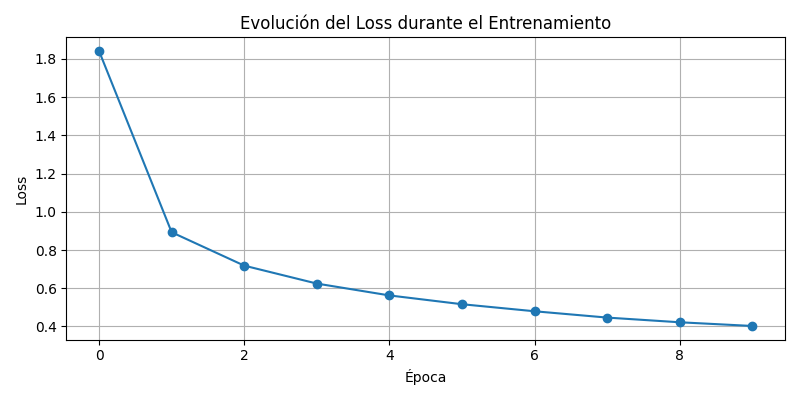

✅ Modelo y tokenizer guardados en: ../models/trained_t5_model_best


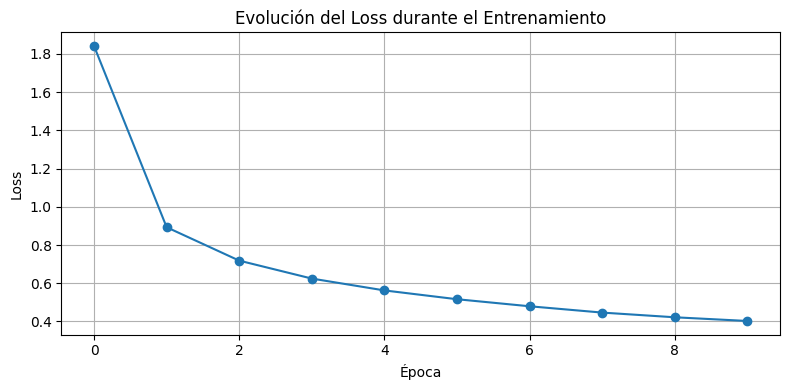

In [217]:
# Paso 1: Cargar y preprocesar los datos
movimientos, plan_contable, diario_contable = leer_datos()
movimientos = preprocesar_movimientos(movimientos)

# Paso 2: Generar pares de entrenamiento
dataset_pairs = generar_pares_movimiento_asiento(movimientos, diario_contable)
exportar_pares_entrenamiento(dataset_pairs)

# Mostrar un ejemplo
print("✅ Ejemplo de par de entrenamiento:")
print("Input:", dataset_pairs[0][0])
print("Output:", dataset_pairs[0][1])

# Paso 3: Tokenizer y modelo
tokenizer = T5Tokenizer.from_pretrained("t5-small")
model = T5ForConditionalGeneration.from_pretrained("t5-small")

# Paso 4: Crear dataset
asientos_dataset = AsientosDataset(dataset_pairs, tokenizer)

# Paso 5: Entrenar modelo (sin interfaz, con gráfico y early stopping opcional)
trained_model = entrenar_modelo(
    asientos_dataset,
    model,
    tokenizer,
    epochs=10,
    batch_size=2,
    use_early_stopping=True,
    guardar_mejor_modelo=True,
    generar_grafica=True
)

# Paso 6: Guardar el modelo entrenado
model_dir = "../models/trained_t5_model_best"
os.makedirs(model_dir, exist_ok=True)
trained_model.save_pretrained(model_dir)
tokenizer.save_pretrained(model_dir)

print(f"✅ Modelo y tokenizer guardados en: {model_dir}")

### **Step 10: We check that the trained model is working properly**

In [23]:
def diagnosticar_modelo(model, tokenizer, dataset_pairs, n_ejemplos=5):
    """
    Verifica si el modelo entrenado ha aprendido algo útil.
    Evalúa su capacidad de reproducir ejemplos del conjunto de entrenamiento.
    """
    import json
    import torch

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    errores = 0
    print(f"\n🧪 Evaluando los primeros {n_ejemplos} ejemplos del dataset de entrenamiento...\n")

    for i, (input_text, expected_output) in enumerate(dataset_pairs[:n_ejemplos]):
        print(f"\n🔹 Ejemplo {i+1}")
        print("Input:", input_text)
        print("Esperado:", expected_output)

        input_ids = tokenizer.encode(input_text, return_tensors="pt", truncation=True, max_length=512).to(device)

        with torch.no_grad():
            generated_ids = model.generate(
                input_ids=input_ids,
                max_length=512,
                num_beams=5,
                early_stopping=True,
                do_sample=False
            )

        output_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
        print("Generado:", output_text)

        if output_text.strip() == "":
            print("❌ Error: el modelo devolvió una cadena vacía.")
            errores += 1
            continue

        output_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
        print("Generado:", output_text)

        # Reparación tentativa del JSON
        reparado = output_text.strip()
        if not reparado.startswith("{"):
            reparado = "{" + reparado
        if not reparado.endswith("}"):
            reparado += "}"
        reparado = reparado.replace("“", '"').replace("”", '"')  # Comillas tipográficas
        reparado = re.sub(r'(\w+)\s*:', r'"\1":', reparado)      # Añadir comillas a claves
        reparado = re.sub(r'",\s*"Cuenta"', r'}, {"Cuenta"', reparado)  # Separar múltiples líneas
        reparado = reparado.replace('Lineas": [', 'Lineas": [ {')  # Asegura apertura correcta
        reparado = reparado.replace(']}', '} ]')  # Asegura cierre correcto
        reparado = re.sub(r",\s*([\]}])", r"\1", reparado)  # Elimina comas colgantes
        reparado = reparado.replace("'", '"')  # Por si hay comillas simples

        try:
            parsed = json.loads(reparado)
            print("✅ El modelo generó un JSON válido (reparado).")
        except Exception as e:
            print(f"⚠️ Aún no es un JSON válido: {e}")
            errores += 1


    print("\n📊 Diagnóstico final:")
    if errores == 0:
        print("✅ Todo correcto: el modelo parece estar aprendiendo bien.")
    else:
        print(f"⚠️ Se detectaron {errores} errores. Puede que el modelo no esté entrenado correctamente.")
    return errores == 0

# Diagnóstico del modelo   
model_dir = "../models/trained_t5_model_best"
trained_model = T5ForConditionalGeneration.from_pretrained(model_dir)
tokenizer = T5Tokenizer.from_pretrained(model_dir)

# Cargar y preparar los datos
movimientos = pd.read_excel("../data_sample/bancos/train_data.xlsx")
movimientos = preprocesar_movimientos(movimientos)  # ← NECESARIO
diario_contable = pd.read_excel("../data_sample/contabilidad/diario_contable.xlsx")

# Generar pares y diagnosticar
dataset_pairs = generar_pares_movimiento_asiento(movimientos, diario_contable)
diagnosticar_modelo(trained_model, tokenizer, dataset_pairs, n_ejemplos=5)


🧪 Evaluando los primeros 5 ejemplos del dataset de entrenamiento...


🔹 Ejemplo 1
Input: Genera asiento contable: 2024-12-31 TRANSFER. EN DIV. 14507.65 CCBPFRPPMAR-TETHYS HOLDING
Esperado: {"Asiento": 3017, "Lineas": [{"Cuenta": 7620000055, "Debe": null, "Haber": 14507.65, "Descripcion": "CUPÓN TETHYS HOLDING"}, {"Cuenta": 5201000003, "Debe": 14507.65, "Haber": null, "Descripcion": "CUPÓN TETHYS HOLDING"}]}
Generado: "Asiento": 2722, "Lineas": ["Cuenta": 4000009126, "Debe": null, "Haber": 14507.65, "Descripcion": "TRASPASO PARA LIQUIDEZ", "Cuenta": 5201000003, "Debe": 14507.65, "Haber": null, "Descripcion": "TRASPASO PARA LIQUIDEZ"]
Generado: "Asiento": 2722, "Lineas": ["Cuenta": 4000009126, "Debe": null, "Haber": 14507.65, "Descripcion": "TRASPASO PARA LIQUIDEZ", "Cuenta": 5201000003, "Debe": 14507.65, "Haber": null, "Descripcion": "TRASPASO PARA LIQUIDEZ"]
⚠️ Aún no es un JSON válido: Expecting ',' delimiter: line 1 column 130 (char 129)

🔹 Ejemplo 2
Input: Genera asiento contable: 

False

### **Step 11: We launch the app to process the new bank movements with the trained model, and evaluate the result**

In [31]:
# Carga el modelo entrenado y lanza la app
lanzar_app_procesamiento(model_path="../models/trained_t5_model_best")

Iniciando procesamiento de movimientos bancarios...
Input text movimiento 0:
Genera asiento contable: 2024-12-31 TRANSFER. EN DIV. 14507.65 CCBPFRPPMAR-TETHYS HOLDING
Asiento generado para movimiento 0:
{'Asiento': 2722, 'Lineas': [{'Cuenta': 4000009126, 'Debe': None, 'Haber': 14507.65, 'Descripcion': 'TRASPASO PARA LIQUIDEZ'}, {'Cuenta': 5201000003, 'Debe': 14507.65, 'Haber': None, 'Descripcion': 'TRASPASO PARA LIQUIDEZ'}]}
--------------------------------------------------
Input text movimiento 1:
Genera asiento contable: 2024-12-31 TGSS.COTIZACION 0 -2499.25 Q2827003A001
Asiento generado para movimiento 1:
{'Asiento': 2722, 'Lineas': [{'Cuenta': 4760000000, 'Debe': 2499.25, 'Haber': None, 'Descripcion': 'LIQ. SEGUROS SOCIALES MARZO 2024'}, {'Cuenta': 5201000003, 'Debe': None, 'Haber': 2499.25, 'Descripcion': 'LIQ. SEGUROS SOCIALES MARZO 2024'}]}
--------------------------------------------------
Input text movimiento 2:
Genera asiento contable: 2024-12-31 TGSS.COTIZACION 0 -718.3 Q2